In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Setup

Is there a significant difference in the amount pledged between the Performances, Theater, and Music Kickstarter categories?

In [31]:
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


# Read kickstarter data
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "kickstarterprojects"

conn_str = f"postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}"

ModuleNotFoundError: No module named 'stats'

<IPython.core.display.Javascript object>

Write a query to get the `category` and amount `pledged` for the `Performances`, `Theater`, and `Music` categories from the `ksprojects` table.

In [24]:
query = """
SELECT category, pledged
FROM ksprojects
WHERE category IN ('Performances', 'Theater', 'Music');
"""

<IPython.core.display.Javascript object>

Run the query and store the output to a pandas DataFrame.

In [25]:
df = pd.read_sql_query(query, con=conn_str)
df.head()

,category,pledged
0,Theater,6575.0
1,Theater,1515.0
2,Theater,800.0
3,Music,13560.0
4,Theater,3850.0


<IPython.core.display.Javascript object>

Descriptively, how do the groups compare?  Make some visualization or print out some stats. 

In [26]:
# performances has a significantly smaller sample size
df.category.value_counts()

Music           2740
Theater         1376
Performances     158
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
#  high skewness and kurtosis values
stats.describe(df.pledged)

DescribeResult(nobs=4274, minmax=(0.0, 123300.0), mean=3947.7857159569485, variance=69161351.33315788, skewness=5.865626950288195, kurtosis=49.411887949118324)

<IPython.core.display.Javascript object>

Let's separate the data into 3 different dataframes for analysis.

In [28]:
performances = df[df.category == "Performances"]
music = df[df.category == "Music"]
theater = df[df.category == "Theater"]

<IPython.core.display.Javascript object>

We have 3 groups and we want to compare their means.  This should trigger your ANOVA neurons to start firing, but we need to make sure our assumption of normality is met before performing this test.  To check for normality we could use any of the methods we've covered.  Here, let's look at QQ plots for each sample.

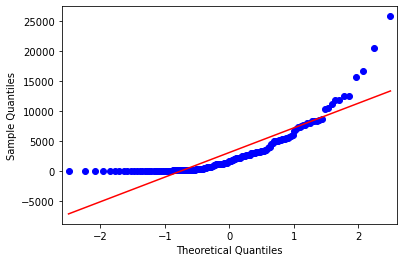

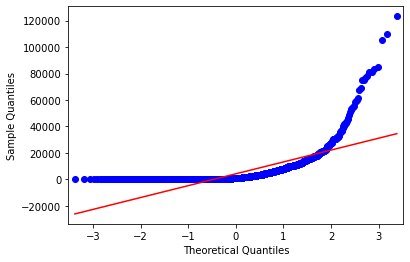

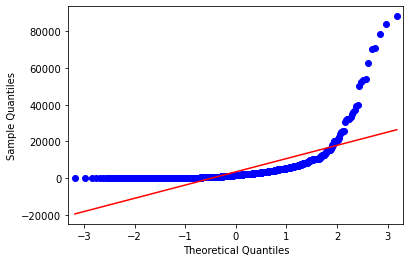

<IPython.core.display.Javascript object>

In [29]:
qqplot(performances.pledged, line="s")
plt.show()

qqplot(music.pledged, line="s")
plt.show()

qqplot(theater.pledged, line="s")
plt.show()

Not looking too normal based on those plots... a non-parametric ANOVA test is the Kruskal Wallis test.  This uses the ranks of our data values rather than the values themselves a good write-up/example of this can be found [here](https://www.statisticshowto.datasciencecentral.com/kruskal-wallis/).  The below list of assumptions is from that linked resource.

> #### Assumptions for the Kruskal Wallis Test
> Your variables should have:
>
> * One independent variable with two or more levels (independent groups). The test is more commonly used when you have three or more levels. For two levels, consider using the Mann Whitney U Test instead.
> * Ordinal scale, Ratio Scale or Interval scale dependent variables.
> * Your observations should be independent. In other words, there should be no relationship between the members in each group or between groups.
> * All groups should have the same shape distributions.

One way to examine the shape could be a histograms by group.  We're roughly the same shape.

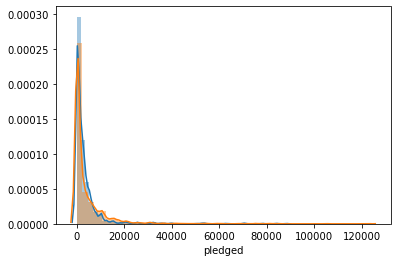

Performances - pledged


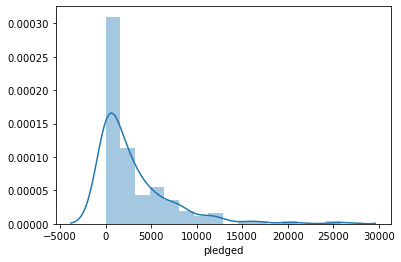

<IPython.core.display.Javascript object>

In [35]:
# print("Theater - pledged")
sns.distplot(theater.pledged)
# plt.show()
# print("Music - pledged")
sns.distplot(music.pledged)
plt.show()
print("Performances - pledged")
sns.distplot(performances.pledged)
plt.show()

Let's move on to performing the test with `scipy.stats`.  Note, that we call this the same way as `stats.f_oneway` (for performing an ANOVA with `scipy.stats`).

In [37]:
_, p = stats.kruskal(theater.pledged, music.pledged, performances.pledged)
print("Reject null: " + str(p < 0.05))

Reject null: True


<IPython.core.display.Javascript object>

So we've concluded at least one median is different.  Time for some post hoc analysis.  We'll be doing multiple tests to determine this, so we need to correct for this compounding chance of a Type I error.

Let's use [`stats.mannwhitneyu()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) to perform these follow up tests. We could possibly reuse the kruskal wallis to acheive the same results; kruskal wallis is a generalization of the mann whitney test to extend it to `n_groups > 2`.

* Perform 3 `stats.mannwhitneyu()` tests to compare each pair of our 3 groups.
* Save all of the outputted p-values to a list.

In [39]:
_, p_mp = stats.kruskal(music["pledged"], performances["pledged"])
_, p_mt = stats.kruskal(music["pledged"], theater["pledged"])
_, p_pt = stats.kruskal(performances["pledged"], theater["pledged"])
print(p_mp)
print(p_mt)
print(p_pt)
p_vals = [p_mp, p_mt, p_pt]

0.3673287936013544
1.3366926137029533e-05
0.6031644959826616


<IPython.core.display.Javascript object>

As mentioned above, we have added risk of committing a Type I error when performing repeated tests like this (Type 1 error - rejecting null when there's really no effect).    The `statsmodels` package provides a [`multipletests()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html) function that can help us mitigate this risk of error (this function was imported at the top of the notebook).

* Use `multipletests()` with your list of p-values to correct for multiple tests.
* What are our conclusions from this analysis?

In [40]:
multipletests(p_vals, method="bonferroni")

(array([False,  True, False]),
 array([1.00000000e+00, 4.01007784e-05, 1.00000000e+00]),
 0.016952427508441503,
 0.016666666666666666)

<IPython.core.display.Javascript object>

Based on our analysis we found:
* The mean rank of at least one of our samples is significantly different than the others
* There is a significant difference in mean rank between the amount pledged for theater and the amount pledged for music

----

**Extra practice**

Repeat the post hoc analysis but using the kruskal wallis test in place of the `stats.mannwhitneyu()`.  Remember, you're still performing multiple tests so you should correct for this increased risk of Type 1 error.  Are the conclusions the same?